Brief description of the problem and data (5 pts) 

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 


In this project we are trying to identify cancer in an image, we are using small image patches that are part of a whole pathology scan. We need to use binary image classification so 1 is there is metastatic cancer in the image and 0 is that there is no cancer present in the image. We need to use a supervised learning technique that uses color (RGB) as the input and we output the binary 0 or 1 for cancer detection.

In terms of NLP, its not exactly an NLP problem but more of a deep learning problem, but somewhat similar in what we need to do like classification, AUC, model generalizations to get our results 

Our data in given in training and testing data of around 200,000 images and around 60,000 images repectively. All of them should be small .tif images of 96 x 96 pixels and should be part of a whole pathology scan and well be using RGB to detect the cancer. 

Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import tensorflow as tf
import os
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import f1_score



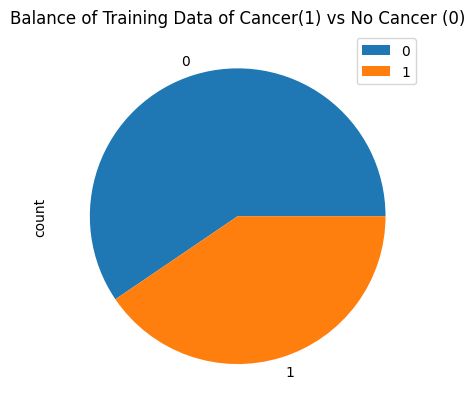

label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


In [2]:
training = pd.read_csv("train_labels.csv")
# training.head()

label_balance_check = training["label"]
label_balance_check.value_counts().plot(kind="pie")

plt.title("Balance of Training Data of Cancer(1) vs No Cancer (0)")
plt.legend()
plt.show()

print(label_balance_check.value_counts(normalize = True))

We can see that no cancer (0) is about 60% of the training data and cancer (1) is about 40% of the training data. This should be fairly good data set to train on for our model

Now lets show some visualizations of our data to see what is really going in them

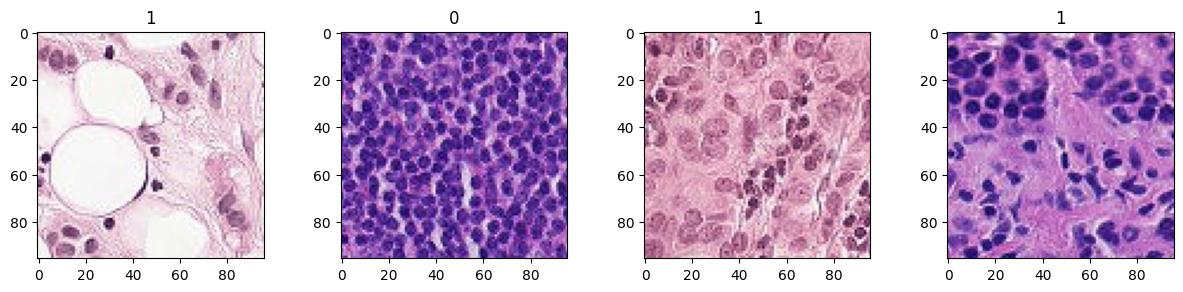

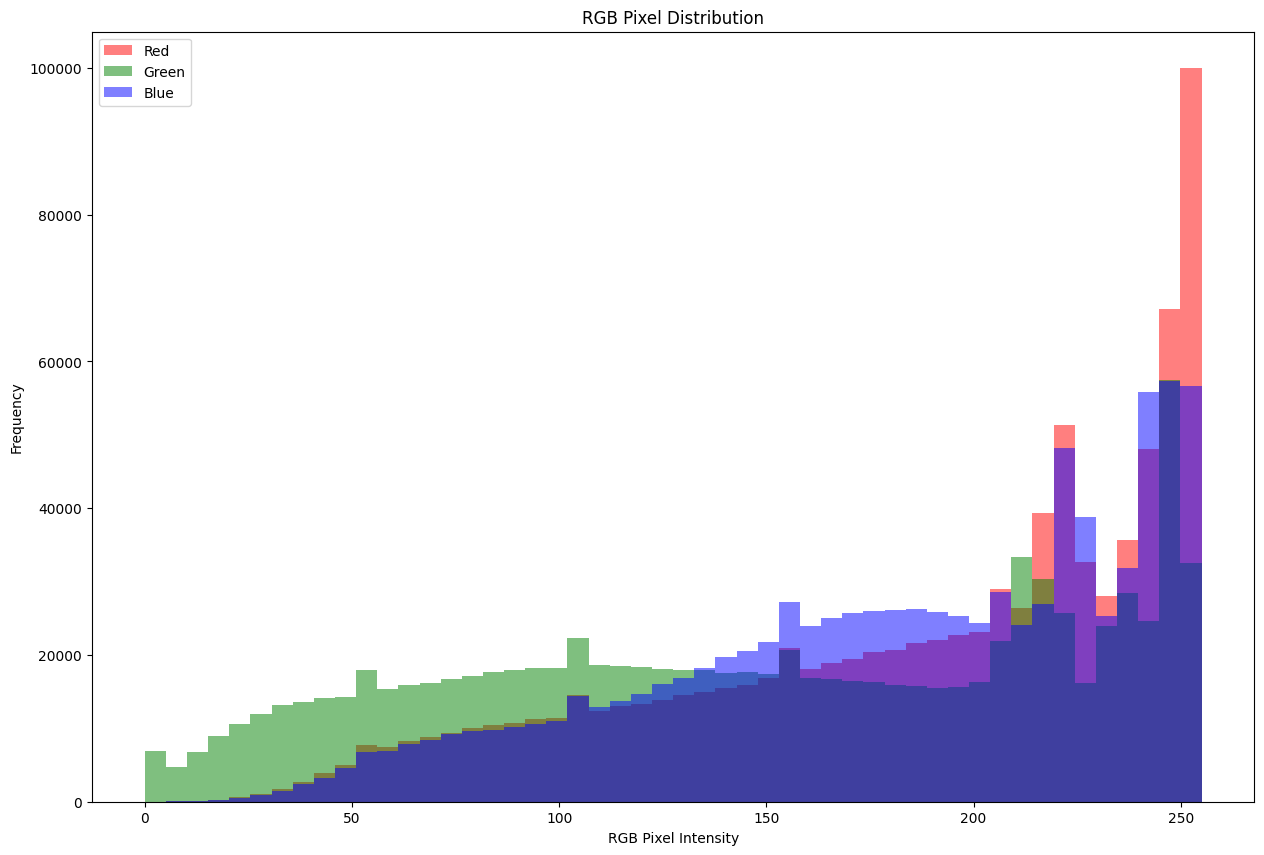

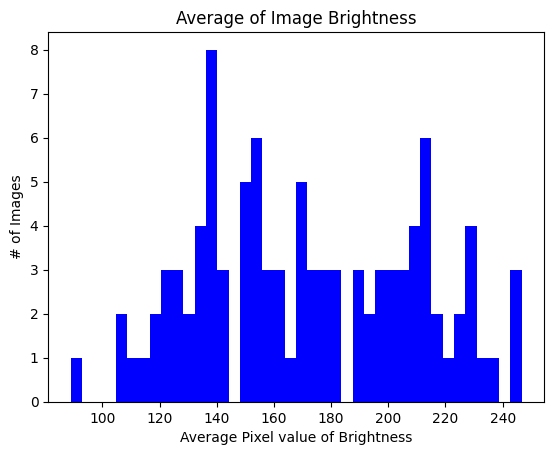

In [3]:
id_example = training.sample(4)["id"].values

plt.figure(figsize = (15,10))

for x, id in enumerate(id_example):
    image = Image.open(f"train/{id}.tif")
    plt.subplot(3,4,x + 1)
    plt.imshow(image)
    plt.title(f"{training.loc[training.id==id,'label'].values[0]}")
    
plt.show()

r = []
g = []
b = []
brightness = []
id_example_big = training.sample(100)["id"].values
for i in id_example_big:
    image = np.array(Image.open(f"train/{i}.tif"))
    # red, green, blues of the images
    r.extend(image[:,:,0].flatten())
    g.extend(image[:,:,1].flatten())
    b.extend(image[:,:,2].flatten())
    # get the image brightness because in our sample we see patches are of different brightness
    brightness.append(image.mean())
    
    
plt.figure(figsize=(15,10))
plt.hist(r, bins=50, alpha=0.5, label='Red', color='red')
plt.hist(g, bins=50, alpha=0.5, label='Green', color='green')
plt.hist(b, bins=50, alpha=0.5, label='Blue', color='blue')
plt.title("RGB Pixel Distribution")
plt.xlabel("RGB Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()
    
plt.hist(brightness, bins = 40, color= "blue")
plt.title("Average of Image Brightness")
plt.xlabel("Average Pixel value of Brightness")
plt.ylabel("# of Images")

plt.show()
    
    
    


Printed out some examples of images that we are going to train with. We can see the ones that don't have cancer(0) and the with cancer(1) with the labels above the image


I did a RGB pixel distribution on sample images, here we can see there is a good variation of rgb values. There is a uptick in red values, so we should do some color normalization 

I aslo did mean pixel brightness on the sample images and it shows there is a wide variety of brightness for the images this means we should do some normalization of the data, and this is expected as images could have different lighting when they were taken. 

Some Cleaning

In [4]:
# check for null values
null_check = training.isnull().sum()
print(null_check)
# check for images that are all white or all black, an unusable image
unusable = []
for i in training["id"].sample(5000):
    image = np.array(Image.open(f"train/{i}.tif"))
    if image.std() < 5:
        unusable.append(i)
print("unusable: ", len(unusable))

# cleaned data
training = training[~training["id"].isin(unusable)]


id       0
label    0
dtype: int64
unusable:  18


So we did some cleaning to our data, we first checked for null values in our images, but we found none. Then we checked for images that were all white or all black and we found them and removed them from training. This is because if an image is fully white or black it provides no value to us in using it in our model. 

Now lets do some planning now that we finished our EDA 


1. We Prepocess our data by Normalizing pixel intensity and rgb intensity
2. Use TensorFlow for our batching 
3. Then we can do some data augmentation 
4. Run a simple CNN model 
5. Then run EfficientNetB0 CNN and tune our hyperparameters to find the best result
6. Find our accuracy and make a submission for the Kaggle competition 

DModel Architecture (25 pts)

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

First were going to do some preprocessing with normalizing our brightness and rbg and then do the CNN model. After we have a baseline model we are then going to use EfficientNetB0 for our next model as it provides us with a better architecture. EfficientNetB0 is good at compound scaling so this is good for these cancer images as it can get the different spatial frequencies very well. EfficientNetB0 is fast to train, easy to tune, and is good at not overfitting which for this large dataset is perfect. We'll compare our custom CNN and EfficientNetB0 below to see how well they perform. However, one issue with EfficientNetB0 is that we need to make sure we tune our learning rate well for it to work well, so that is going to be our most important hyperparameter. 

In [5]:
image_size = 96

def load_image(id):

    path = os.path.join("train", id + ".tif")
    
    
    image = Image.open(path)
    image = image.resize((96,96))
    image = np.array(image).astype("float32") / 255.0
    
    return image

def load_image_tf(path):
    if isinstance(path, tf.Tensor):
        path = path.numpy().decode("utf-8") 

    basename = os.path.basename(path)  
    id = os.path.splitext(basename)[0]    

    return load_image(id)  

id_example = training["id"].sample(5000, random_state=42).values
# get the RGB mean and std
p = []
for i in id_example:
    image = load_image(i)
    p.append(image)
p = np.stack(p, axis = 0)

mean = p.mean(axis= (0,1,2))
std = p.std(axis= (0,1,2))
print("mean: ", mean, "std: ", std)
# use the rgb mean in the normalization
normalize = layers.Normalization(axis = -1)
normalize.adapt(p)


# preprocessing image
def preprocess(path, label):
    image = tf.py_function(load_image_tf, [path], Tout = tf.float32)
    image.set_shape((96,96,3))
    return image, tf.cast(label, tf.float32)
# make new dataset
def dataset(data, batch_size = 64, shuffle = True):
    path = []
    for i in data["id"]:
        path.append("train/" + i + ".tif")
        
    label = data["label"].values
    data_set = tf.data.Dataset.from_tensor_slices((path,label))
    data_set = data_set.map(preprocess, num_parallel_calls= tf.data.AUTOTUNE)
    if shuffle:
        data_set = data_set.shuffle(buffer_size=2048)
    data_set = data_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return data_set
# data augmentation
augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                                      layers.RandomRotation(0.1),
                                                      layers.RandomZoom(0.1)])


new_training = dataset(training.sample(frac = 0.8, random_state=42))
new_val = dataset(training.drop(training.sample(frac= 0.8, random_state= 42).index),shuffle = False)

mean:  [0.3640889 0.3640889 0.3640889] std:  [0.41322356 0.31900382 0.3855422 ]


Now we have rescaled, normalized (brightness and RBG) and did data augmentation, So we are now ready to plug our data into a CNN model 

CCN implementation

In [6]:
def build_cnn():
    input_cnn = tf.keras.Input(shape=(96,96,3))
    # scale RGB, normalize RGB and Brightness and augment the data using what 
    # the functions we made
    cnn = layers.Rescaling(1.0/255)(input_cnn)
    
    cnn = normalize(cnn)
    
    cnn = augmentation(cnn)
    # convolution block 1
    cnn = layers.Conv2D(32, (3,3), padding = "same" , activation = "relu")(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.MaxPooling2D((2,2,))(cnn)
    # convolution block 2
    cnn = layers.Conv2D(64, (3,3), padding = "same" , activation = "relu")(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.MaxPooling2D((2,2,))(cnn)
    # convolution block 3
    cnn = layers.Conv2D(128, (3,3), padding = "same" , activation = "relu")(cnn)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.MaxPooling2D((2,2,))(cnn)
    
    # connecting layer
    cnn = layers.GlobalAveragePooling2D()(cnn)
    cnn = layers.Dense(128, activation= "relu")(cnn)
    # help with overfitting
    cnn = layers.Dropout(0.5)(cnn)
    # output for inary classification
    output_cnn = layers.Dense(1, activation= "sigmoid")(cnn)
    # build our model
    cnn_model = models.Model(input_cnn, output_cnn, name = "CNN")
    return cnn_model 
    
    
cnn_model = build_cnn()
cnn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-3), loss = "binary_crossentropy", metrics = ["accuracy"])
cnn_model.summary()
    

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 96, 96, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,792 (432.79 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 455 (1.78 KB)

Our CCN has RGB and Brightness normalization, convolution and pooling layers, does batch normalization. This is our basic CNN model and we can now iterate on it.

Now let's try a model that is a pretrained CNN, I am going to use EfficientNetB0 to do this. This model should have its own preprocess input and we should see an increase of performance with this pretrained model 

In [ ]:
def pretrained_cnn(train = False):
    model = EfficientNetB0(include_top= False, weights= "imagenet", input_shape=(96,96,3))
    
    model.trainable = train
    cnn_input = tf.keras.Input(shape = (96,96,3))
    cnn = preprocess_input(cnn_input)
    cnn = model(cnn, training = False)
    cnn = layers.GlobalAveragePooling2D()(cnn)
    cnn = layers.Dropout(0.4)(cnn)
    cnn = layers.Dense(128, activation= "relu")(cnn)
    cnn = layers.Dropout(0.3)(cnn)
    cnn_output = layers.Dense(1, activation= "sigmoid")(cnn)
    
    model = models.Model(cnn_input, cnn_output, name = "EfficientNet_CNN")
    return model

# this will fail my code later on because we iterate on this model, I put the results below,
# but commented it out if for people who want to run this notebook

# efficientnet_cnn = pretrained_cnn(train = False)

# efficientnet_cnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-4), loss = "binary_crossentroy", metrics = ["accuracy"])


# efficientnet_cnn.summary()


Model: "EfficientNet_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

We did see improvement with this pretrained model as expected.

Results and Analysis (35 pts) 

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.




Now were going test some hyperparameters to see where we can improve in our model. We are then going to tune them so our final model is more accurate with those hyperparameters. 

In [81]:

smaller_train = new_training.take(40)
smaller_val = new_val.take(20)

# our pretrained CNN from before but we allow for different hyperparameters
def pretrained_cnn2(
    dense_units=128,
    dropout1=0.4,
    dropout2=0.3,
    learning_rate=1e-4,
    train=False
):

    base = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(96, 96, 3)
    )
    base.trainable = train   

    cnn_input = tf.keras.Input(shape=(96, 96, 3))

    cnn = preprocess_input(cnn_input)
    cnn = base(cnn, training=train)   

    cnn = layers.GlobalAveragePooling2D()(cnn)
    cnn = layers.Dropout(dropout1)(cnn)
    cnn = layers.Dense(dense_units, activation="relu")(cnn)
    cnn = layers.Dropout(dropout2)(cnn)

    cnn_output = layers.Dense(1, activation="sigmoid")(cnn)

    model = models.Model(cnn_input, cnn_output, name="EfficientNet_Tuned")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",  
        metrics=["accuracy"]
    )

    return model



learning_rates = [1e-2, 1e-3, 3e-4, 1e-4]

tuning_histories = {} 

for l in learning_rates:
    print(l)
    
    model = pretrained_cnn2(
        learning_rate=l,
        train=False 
    )
    
    history = model.fit(
        smaller_train,
        validation_data=smaller_val,
        epochs=3,
        verbose=0
    )
    tuning_histories[l] = history.history
    
    best_val_acc = max(history.history["val_accuracy"])
    best_val_loss = min(history.history["val_loss"])
    print("best validation accuracy: ", best_val_acc)
    print("best validation loss: ", best_val_loss)


0.01
best validation accuracy:  0.6070312261581421
best validation loss:  0.6696165800094604
0.001
best validation accuracy:  0.6070312261581421
best validation loss:  0.670512318611145
0.0003
best validation accuracy:  0.6070312261581421
best validation loss:  0.6698836088180542
0.0001
best validation accuracy:  0.6070312261581421
best validation loss:  0.6714514493942261


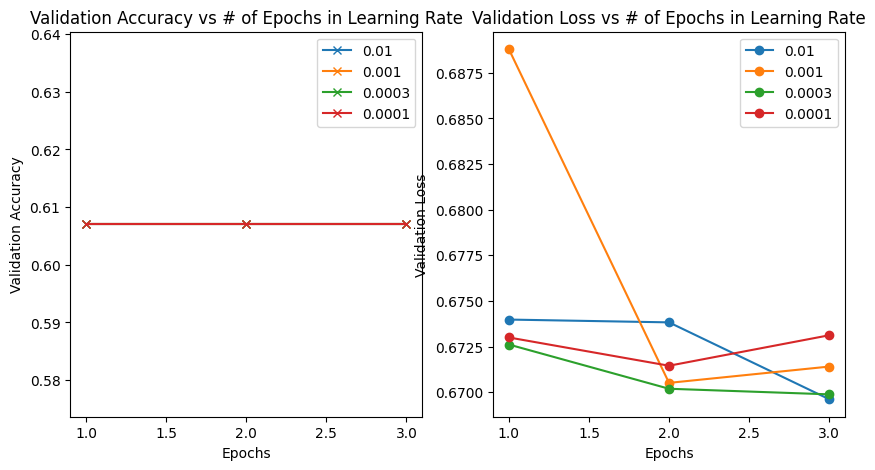

In [82]:
epoch = np.arange(1, 4)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
for l, h in tuning_histories.items():
    plt.plot(epoch, h["val_accuracy"], marker="x", label=l)
plt.title("Validation Accuracy vs # of Epochs in Learning Rate")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.subplot(1,2,2)
for l, h in tuning_histories.items():
    plt.plot(epoch, h["val_loss"], marker="o", label=l)
plt.title("Validation Loss vs # of Epochs in Learning Rate")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

Note: all our validation accuracies were the same so it just shows as one line in the plot

analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary:


After running some tuning on different models and architectures, I focused on the learning rate and how we can tune that valid in order to get better results. Learning rate is a major factor in how stable and reliable a model is and has the most impact on training. I chose to focused on learning rate because the other hyperparameters here would have less impact.  

I tested learning_rates = [1e-2, 1e-3, 3e-4, 1e-4] ranging from a large learning rate to a small learning rate, we tested on 3 epochs and got the validation acuracy and validation loss.

Our best validation accuracy was 0.6070, however this came from every single epoch, so the learning rate had no effect on the accuracy. However, with our validation loss we saw that 0.0003 had a val loss of 0.669 which was the best so for validation loss accuracy learning rate did have an effect on it. 

So for my hyperparameter tuning on the EfficientNetB0 I will choose a learning rate of 0.0003 because it gave us the lowest validation loss and allows the model to preserve pretrained features better and helps the classifer. This had the best balance of stability with good speed as opposited to 1e-4. 

Doing EfficientNetB0 CNN and optimizing my learning rate hyperparameters is going to help our accuracy overall, although it wasn't the metric I expected for the hyperparameters, it still going to help in the long run. 

Train the model on all the training data now and then make a submission csv for the kaggle competition

In [ ]:
final_cnn = pretrained_cnn2(
    learning_rate = 3e-4,
    train = False 
)

history_final = final_cnn.fit(
    new_training,
    validation_data = new_val,
    epochs = 10
)





Epoch 1/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 411s 148ms/step - accuracy: 0.5941 - loss: 0.6762 - val_accuracy: 0.5939 - val_loss: 0.6736
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 428s 155ms/step - accuracy: 0.5952 - loss: 0.6739 - val_accuracy: 0.5939 - val_loss: 0.6728
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 393s 143ms/step - accuracy: 0.5952 - loss: 0.6726 - val_accuracy: 0.5939 - val_loss: 0.6739
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 402s 146ms/step - accuracy: 0.5952 - loss: 0.6718 - val_accuracy: 0.5939 - val_loss: 0.6702
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 406s 147ms/step - accuracy: 0.5952 - loss: 0.6699 - val_accuracy: 0.5939 - val_loss: 0.6683
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 399s 145ms/step - accuracy: 0.5952 - loss: 0.6688 - val_accuracy: 0.5939 - val_loss: 0.6687
Epoch 7/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 393s 143ms/step - accuracy: 0.5952 - loss: 0.6674 - val_accuracy: 0.5939 - val_loss: 0.6672
Epoch 8/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 391s 142ms/step - ac

In [ ]:
from sklearn.metrics import f1_score
val_images = new_val.map(lambda x, y: x)
val_labels_true = np.concatenate([y.numpy().ravel() for _, y in new_val])

val_probs = final_cnn.predict(val_images).ravel()

thresholds = np.linspace(0.42,0.47,51) 
best_t = 0.5
best_f1 = -1

for t in thresholds:
    val_pred = (val_probs > t).astype(int)
    f1 = f1_score(val_labels_true, val_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print(best_t,best_f1)

688/688 ━━━━━━━━━━━━━━━━━━━━ 57s 82ms/step
Best threshold: 0.44499999999999995 Best F1: 0.6026945952038286


In [ ]:

test_df = pd.read_csv("sample_submission.csv") 
test_ids = test_df["id"].astype(str).values
test_paths = np.array([os.path.join("test", img_id + ".tiff") for img_id in test_ids])  

def load_tif(img_id):

    img_id = img_id.numpy().decode("utf-8")

    path = os.path.join("test", img_id + ".tif")
    
    img = Image.open(path)
    arr = np.array(img)
    return arr

def preprocess_test(path):
    image = tf.py_function(load_tif, [path], Tout=tf.uint8)
    image.set_shape([96, 96, 3])
    image = tf.image.resize(image, (96, 96))
    image = tf.cast(image, tf.float32) / 255.0
    return image

test_data = tf.data.Dataset.from_tensor_slices(test_ids)
test_data = (
    test_data
    .map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

pred_probs = final_cnn.predict(test_data).ravel()
pred_labels = (pred_probs > best_t).astype(int)

submission = pd.DataFrame({
    "id": test_ids,
    "label": pred_labels
})

submission.head()

898/898 ━━━━━━━━━━━━━━━━━━━━ 87s 97ms/step


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,1
1,95596b92e5066c5c52466c90b69ff089b39f2737,1
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,1
3,2c35657e312966e9294eac6841726ff3a748febf,1
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [65]:
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")


Saved submission.csv


Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?



Overall, after doing multiple modelis, chaning hyperparameters, and different strategies to improve performance I think I ended up in a good spot for my model. Some things that work well was good preprocessing because this helped as we continued to run different models many times and helped with stabiliting validation performance. I was also happy with the EfficientNet architecture choice because this pretrained model had great validation accuracy without many epochs. Also, tuning learning rate lower to 3e-4 also proved to help validation scores as well. 

Things that didn't help were having too big of a model size as this didn't help improve my validation and doing too many augmentations to the data caused it to hurt my performance. 

In the future it might be beneficial to use better augmentation strategies because this is something I was not able to implement and this would help increase the diversity of images. It would also be interesting to do other architechture approaches that I didn't do like ConvNeXt. 


References:
For EfficientNet
https://arxiv.org/abs/1905.11946
Tensor flow
https://www.tensorflow.org/

TFIDF
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html